In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import math
from SimpleTorch import Tensor, no_grad
from SimpleTorch.data_tools import Dataset, DataLoader
from SimpleTorch.operators import ReLU, MSELoss
from SimpleTorch.modules import Module, Linear, Sequential
from SimpleTorch.optim import SGD


---
## 准备数据

In [2]:
sample_num = 100
a, b, c, d = 1, 2, 3, 4
x = np.random.rand(sample_num) * 2 * math.pi - math.pi
y = a * np.cos(b * x) + c * np.sin(d * x)

In [3]:
x = np.expand_dims(x, axis=1)
y = np.expand_dims(y, axis=1)

In [4]:
print(x.shape, y.shape)
print(x.dtype, y.dtype)

(100, 1) (100, 1)
float64 float64


---
### 特征工程

In [5]:
x_feature = []
for i in range(1, 4):
    temp = x ** i
    x_feature.append(temp)

In [6]:
x_feature = np.concatenate(x_feature, axis=1)
print(x_feature.shape)

(100, 3)


In [7]:
class MyDataset(Dataset):
    def __init__(self, x, y):
        super(MyDataset, self).__init__()
        self.x = x
        self.y = y
    
    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        return self.x[index], self.y[index]

In [8]:
ratio = 0.8
train_sample_num = int(sample_num * ratio)
train_dataset = MyDataset(x_feature[0:train_sample_num], y[0:train_sample_num])
test_dataset = MyDataset(x_feature[train_sample_num:], y[train_sample_num:])

In [9]:
print(len(train_dataset), len(test_dataset))

80 20


---
### 可视化数据看一眼

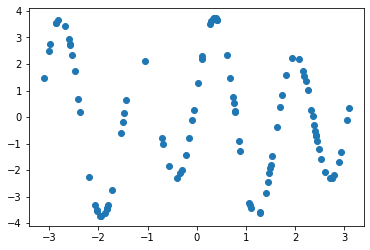

In [10]:
plt.scatter(x, y)

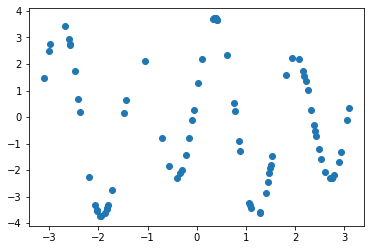

In [11]:
plt.scatter(x[0:train_sample_num], y[0:train_sample_num])

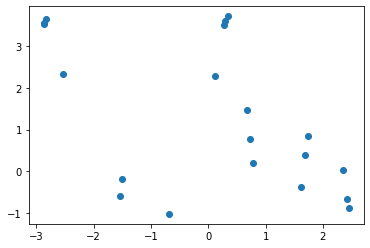

In [12]:
plt.scatter(x[train_sample_num:], y[train_sample_num:])

In [13]:
train_dataloader = DataLoader(train_dataset, batch_size=50, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=50)

In [14]:
temp = next(iter(train_dataloader))
print(type(temp))
print(len(temp))
print(type(temp[0]), type(temp[1]))
print(temp[0].shape, temp[0].dtype)
print(temp[1].shape, temp[1].dtype)

<class 'list'>
2
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(50, 3) float64
(50, 1) float64


---
## 模型部分

In [15]:
class MLP(Module):
    def __init__(self, feature_num, layer_num, units):
        super(MLP, self).__init__()
        
        layers = []
        for i in range(layer_num):
            if i == 0:
                layers += [Linear(feature_num, units[i]),
                            ReLU()]
            else:
                layers += [Linear(units[i - 1], units[i]),
                            ReLU()]
        layers += [Linear(units[-1], 1)]
        
        self.layers = Sequential(*layers)
    
    def forward(self, x):
        y = self.layers(x)

        return y

In [16]:
def train_loop(dataloader, model, loss_fn, optimizer, total_epoch, cur_epoch, show_gap, update_gap):
    if cur_epoch % show_gap == 0:
        pbar = tqdm(dataloader, desc=f'Epoch {cur_epoch}/{total_epoch}', unit='batch')
    else:
        pbar = dataloader

    for i, (x, y) in enumerate(pbar):
        x = Tensor(x)
        y = Tensor(y)

        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()

        if cur_epoch % show_gap == 0 and i % update_gap == 0:
            pbar.set_postfix_str(f'loss={loss.data.item():.4f}')

In [17]:
def test_loop(dataloader, model, loss_fn, cur_epoch, show_gap):
    steps = len(dataloader)
    loss = 0.0
    
    with no_grad():
        for x, y in dataloader:
            x = Tensor(x)
            y = Tensor(y)

            y_pred = model(x)
            loss += loss_fn(y_pred, y).data.item()
    
    loss = loss / steps

    if cur_epoch % show_gap == 0:
        print(f'test_loss={loss:.4f}')

---
## 开始训练

In [18]:
mlp = MLP(3, 3, [8, 16, 32])
print(mlp)

In [19]:
for name, param in mlp.parameters:
    print(name, param.data.shape, param.data.dtype)

layers_0_weight (8, 3) float64
layers_0_bias (8,) float64
layers_2_weight (16, 8) float64
layers_2_bias (16,) float64
layers_4_weight (32, 16) float64
layers_4_bias (32,) float64
layers_6_weight (1, 32) float64
layers_6_bias (1,) float64


In [20]:
loss_fn = MSELoss()
optimizer = SGD(mlp.parameters, lr=0.01)

In [21]:
epochs = 10000
show_gap = 50
update_gap = 1
for i in range(epochs):
    train_loop(train_dataloader, mlp, loss_fn, optimizer, epochs, i, show_gap, update_gap)
    test_loop(test_dataloader, mlp, loss_fn, i, show_gap)

Epoch 0/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=4.0283


Epoch 50/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=4.6177


Epoch 100/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=4.5432


Epoch 150/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=2.4731


Epoch 200/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=1.4151


Epoch 250/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.8167


Epoch 300/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.4013


Epoch 350/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.2582


Epoch 400/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=1.3829


Epoch 450/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.1170


Epoch 500/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.6091


Epoch 550/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.1026


Epoch 600/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.1615


Epoch 650/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.1975


Epoch 700/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.1570


Epoch 750/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.3929


Epoch 800/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.1379


Epoch 850/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.2800


Epoch 900/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.1458


Epoch 950/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.1283


Epoch 1000/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.2794


Epoch 1050/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.2547


Epoch 1100/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.2296


Epoch 1150/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.2518


Epoch 1200/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.2765


Epoch 1250/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.3712


Epoch 1300/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.3015


Epoch 1350/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0945


Epoch 1400/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.2326


Epoch 1450/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0501


Epoch 1500/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0442


Epoch 1550/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.2076


Epoch 1600/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.1705


Epoch 1650/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0872


Epoch 1700/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0544


Epoch 1750/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0804


Epoch 1800/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.1321


Epoch 1850/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0434


Epoch 1900/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.1114


Epoch 1950/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0627


Epoch 2000/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0731


Epoch 2050/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0653


Epoch 2100/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.1061


Epoch 2150/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0259


Epoch 2200/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0534


Epoch 2250/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.1908


Epoch 2300/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0432


Epoch 2350/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.1814


Epoch 2400/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0435


Epoch 2450/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0364


Epoch 2500/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0221


Epoch 2550/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0364


Epoch 2600/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0545


Epoch 2650/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0286


Epoch 2700/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.1489


Epoch 2750/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0434


Epoch 2800/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.1079


Epoch 2850/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0846


Epoch 2900/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0521


Epoch 2950/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0433


Epoch 3000/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0744


Epoch 3050/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.1032


Epoch 3100/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.1292


Epoch 3150/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0896


Epoch 3200/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0305


Epoch 3250/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.1242


Epoch 3300/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.1104


Epoch 3350/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0493


Epoch 3400/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0136


Epoch 3450/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0579


Epoch 3500/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.1299


Epoch 3550/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.1070


Epoch 3600/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0478


Epoch 3650/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0285


Epoch 3700/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0121


Epoch 3750/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0271


Epoch 3800/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0320


Epoch 3850/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0775


Epoch 3900/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0335


Epoch 3950/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0429


Epoch 4000/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0402


Epoch 4050/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0408


Epoch 4100/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.1067


Epoch 4150/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0326


Epoch 4200/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.1167


Epoch 4250/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0454


Epoch 4300/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0461


Epoch 4350/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0920


Epoch 4400/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0811


Epoch 4450/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0416


Epoch 4500/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0278


Epoch 4550/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0374


Epoch 4600/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0954


Epoch 4650/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0215


Epoch 4700/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0101


Epoch 4750/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0247


Epoch 4800/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0467


Epoch 4850/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.1054


Epoch 4900/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.1106


Epoch 4950/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0745


Epoch 5000/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0700


Epoch 5050/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0262


Epoch 5100/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0290


Epoch 5150/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0820


Epoch 5200/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0604


Epoch 5250/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0247


Epoch 5300/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0377


Epoch 5350/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0765


Epoch 5400/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0266


Epoch 5450/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0177


Epoch 5500/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0854


Epoch 5550/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0936


Epoch 5600/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0509


Epoch 5650/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0472


Epoch 5700/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0478


Epoch 5750/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0186


Epoch 5800/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0161


Epoch 5850/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0395


Epoch 5900/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0231


Epoch 5950/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0170


Epoch 6000/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0474


Epoch 6050/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.1096


Epoch 6100/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0364


Epoch 6150/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0223


Epoch 6200/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0132


Epoch 6250/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0267


Epoch 6300/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0558


Epoch 6350/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0275


Epoch 6400/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0118


Epoch 6450/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0696


Epoch 6500/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0230


Epoch 6550/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0377


Epoch 6600/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0339


Epoch 6650/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0284


Epoch 6700/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0363


Epoch 6750/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0192


Epoch 6800/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0137


Epoch 6850/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0123


Epoch 6900/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0095


Epoch 6950/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0257


Epoch 7000/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0130


Epoch 7050/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0084


Epoch 7100/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0140


Epoch 7150/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0197


Epoch 7200/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0257


Epoch 7250/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0097


Epoch 7300/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0629


Epoch 7350/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0139


Epoch 7400/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0155


Epoch 7450/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0130


Epoch 7500/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0241


Epoch 7550/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0110


Epoch 7600/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0452


Epoch 7650/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0105


Epoch 7700/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0226


Epoch 7750/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0165


Epoch 7800/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0140


Epoch 7850/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0214


Epoch 7900/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0162


Epoch 7950/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0297


Epoch 8000/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0423


Epoch 8050/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0156


Epoch 8100/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0119


Epoch 8150/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0126


Epoch 8200/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0083


Epoch 8250/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0236


Epoch 8300/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0099


Epoch 8350/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0156


Epoch 8400/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0149


Epoch 8450/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0130


Epoch 8500/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0186


Epoch 8550/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0241


Epoch 8600/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0194


Epoch 8650/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0138


Epoch 8700/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0170


Epoch 8750/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0115


Epoch 8800/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0165


Epoch 8850/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0181


Epoch 8900/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0162


Epoch 8950/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0184


Epoch 9000/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0070


Epoch 9050/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0259


Epoch 9100/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0119


Epoch 9150/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0093


Epoch 9200/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0274


Epoch 9250/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0105


Epoch 9300/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0165


Epoch 9350/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0100


Epoch 9400/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0248


Epoch 9450/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0101


Epoch 9500/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0078


Epoch 9550/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0129


Epoch 9600/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0138


Epoch 9650/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0153


Epoch 9700/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0096


Epoch 9750/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0164


Epoch 9800/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0121


Epoch 9850/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0115


Epoch 9900/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0092


Epoch 9950/10000:   0%|          | 0/2 [00:00<?, ?batch/s]

test_loss=0.0097


---
## 看一下模型拟合的效果

#### 训练集 

In [22]:
with no_grad():
    temp = Tensor(x_feature[:train_sample_num])
    y_pred = mlp(temp)
    print(y_pred.data.shape)

(80, 1)


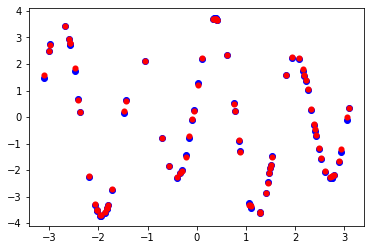

In [23]:
plt.scatter(x[:train_sample_num], y[:train_sample_num], c='b')
plt.scatter(x[:train_sample_num], y_pred.data, c='r', linewidths=0.1)

#### 测试集

In [24]:
with no_grad():
    temp = Tensor(x_feature[train_sample_num:])
    y_pred = mlp(temp)
    print(y_pred.data.shape)

(20, 1)


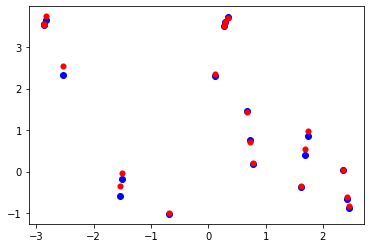

In [25]:
plt.scatter(x[train_sample_num:], y[train_sample_num:], c='b')
plt.scatter(x[train_sample_num:], y_pred.data, c='r', linewidths=0.1)